# Gibbs textural filters comparison on BRATS data

We compare the performance of models trained on stylized datasets on differently stylized datasets.



The dataset comes from http://medicaldecathlon.com/.  
Target: Gliomas segmentation necrotic/active tumour and oedema  
Modality: Multimodal multisite MRI data (FLAIR, T1w, T1gd,T2w)  
Size: 750 4D volumes (484 Training + 266 Testing)  
Source: BRATS 2016 and 2017 datasets.  
Challenge: Complex and heterogeneously-located targets

Below figure shows image patches with the tumor sub-regions that are annotated in the different modalities (top left) and the final labels for the whole dataset (right).
(Figure taken from the [BraTS IEEE TMI paper](https://ieeexplore.ieee.org/document/6975210/))

![image](../figures/brats_tasks.png)

The image patches show from left to right:
1. the whole tumor (yellow) visible in T2-FLAIR (Fig.A).
1. the tumor core (red) visible in T2 (Fig.B).
1. the enhancing tumor structures (light blue) visible in T1Gd, surrounding the cystic/necrotic components of the core (green) (Fig. C).
1. The segmentations are combined to generate the final labels of the tumor sub-regions (Fig.D): edema (yellow), non-enhancing solid core (red), necrotic/cystic core (green), enhancing core (blue).

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Project-MONAI/tutorials/blob/master/3d_segmentation/brats_segmentation_3d.ipynb)

## Setup imports

In [1]:
import os
import shutil
import tempfile

import matplotlib.pyplot as plt
import numpy as np
from monai.apps import DecathlonDataset
from monai.config import print_config
from monai.data import DataLoader
from monai.losses import DiceLoss
from monai.metrics import DiceMetric
from monai.networks.nets import UNet
from monai.transforms import (
    Activations,
    AsChannelFirstd,
    AsDiscrete,
    CenterSpatialCropd,
    Compose,
    LoadImaged,
    MapTransform,
    NormalizeIntensityd,
    Orientationd,
    RandFlipd,
    RandScaleIntensityd,
    RandShiftIntensityd,
    RandSpatialCropd,
    Spacingd,
    ToTensord,
)
from monai.utils import set_determinism

import torch
from torch.utils.data import random_split
from tqdm import tqdm
import pickle

############################################
# Local imports

SOURCE_CODE_PATH = '/homes/yc7620/Documents/medical-vision-textural-bias/source_code/'
import sys
sys.path.append(SOURCE_CODE_PATH)

from filters_and_operators import (ConvertToMultiChannelBasedOnBratsClassesd,
                                   SelectChanneld,
                                   RandFourierDiskMaskd)

from utils import show_slice_and_fourier, ReCompose, BratsValIterDataset, model_evaluation
#############################################

# set determinism for reproducibility
set_determinism(seed=0)


root_dir = '/vol/bitbucket/yc7620/90_data/52_MONAI_DATA_DIRECTORY/'
print('root_dir', root_dir)
print_config()

device = torch.device("cuda:0")

root_dir /vol/bitbucket/yc7620/90_data/52_MONAI_DATA_DIRECTORY/
MONAI version: 0.5.dev2113
Numpy version: 1.19.2
Pytorch version: 1.8.0
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: b3cc668c924b2a7e6b822416f4d920a098c27704

Optional dependencies:
Pytorch Ignite version: 0.4.4
Nibabel version: 3.2.1
scikit-image version: 0.17.2
Pillow version: 8.1.2
Tensorboard version: 1.15.0
gdown version: 3.12.2
TorchVision version: 0.9.0
ITK version: NOT INSTALLED or UNKNOWN VERSION.
tqdm version: 4.50.2
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## Setup transforms for each dataset

In [2]:
val_transform_baseline_FLAIR = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AsChannelFirstd(keys="image"),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        CenterSpatialCropd(keys=["image", "label"], roi_size=[128, 128, 64]),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        ToTensord(keys=["image", "label"]),
        SelectChanneld(["image", "label"], (0, 1))
    ]
)

val_transform_baseline_T2 = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AsChannelFirstd(keys="image"),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        CenterSpatialCropd(keys=["image", "label"], roi_size=[128, 128, 64]),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        ToTensord(keys=["image", "label"]),
        SelectChanneld(["image", "label"], (3, 0))
    ]
)

val_transform_gibbs12p5_FLAIR = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AsChannelFirstd(keys="image"),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        CenterSpatialCropd(keys=["image", "label"], roi_size=[128, 128, 64]),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        ToTensord(keys=["image", "label"]),
        RandFourierDiskMaskd(keys='image', r=12.5 , inside_off=False, prob=1.),
        SelectChanneld(["image", "label"], (0, 1))
    ]
)

val_transform_gibbs20_FLAIR = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AsChannelFirstd(keys="image"),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        CenterSpatialCropd(keys=["image", "label"], roi_size=[128, 128, 64]),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        ToTensord(keys=["image", "label"]),
        RandFourierDiskMaskd(keys='image', r=20 , inside_off=False, prob=1.),
        SelectChanneld(["image", "label"], (0, 1))
    ]
)

## Load data with DecathlonDataset

In [3]:
# baseline FLAIR
val_ds_baseline_FLAIR = DecathlonDataset(
    root_dir=root_dir,
    task="Task01_BrainTumour",
    transform=val_transform_baseline_FLAIR,
    section="validation",
    download=False,
    num_workers=4,
    cache_num=50
)

_ , test_ds_baseline_FLAIR = random_split(val_ds_baseline_FLAIR, [48, 48],
                                   torch.Generator().manual_seed(0))
test_loader_baseline_FLAIR = DataLoader(test_ds_baseline_FLAIR, batch_size=2, shuffle=False, num_workers=4)


# baseline T2
val_ds_baseline_T2 = DecathlonDataset(
    root_dir=root_dir,
    task="Task01_BrainTumour",
    transform=val_transform_baseline_T2,
    section="validation",
    download=False,
    num_workers=4,
    cache_num=50
)

_ , test_ds_baseline_T2 = random_split(val_ds_baseline_T2, [48, 48],
                                   torch.Generator().manual_seed(0))
test_loader_baseline_T2 = DataLoader(test_ds_baseline_T2, batch_size=2, shuffle=False, num_workers=4)

#Gibbs12.5
val_ds_gibbs12p5_FLAIR = DecathlonDataset(
    root_dir=root_dir,
    task="Task01_BrainTumour",
    transform=val_transform_gibbs12p5_FLAIR,
    section="validation",
    download=False,
    num_workers=4,
    cache_num=50
)
_ , test_ds_gibbs12p5_FLAIR = random_split(val_ds_gibbs12p5_FLAIR, [48, 48],
                                   torch.Generator().manual_seed(0))

test_loader_gibbs12p5_FLAIR = DataLoader(test_ds_gibbs12p5_FLAIR, batch_size=2, shuffle=False, num_workers=4)

#Gibbs20
val_ds_gibbs20_FLAIR = DecathlonDataset(
    root_dir=root_dir,
    task="Task01_BrainTumour",
    transform=val_transform_gibbs20_FLAIR,
    section="validation",
    download=False,
    num_workers=4,
    cache_num=50
)
_ , test_ds_gibbs20_FLAIR = random_split(val_ds_gibbs20_FLAIR, [48, 48],
                                   torch.Generator().manual_seed(0))

test_loader_gibbs20_FLAIR = DataLoader(test_ds_gibbs20_FLAIR, batch_size=2, shuffle=False, num_workers=4)

Loading dataset: 100%|██████████| 50/50 [00:32<00:00,  1.54it/s]


## Check data shape and visualize

torch.Size([1, 128, 128, 64])
torch.Size([1, 128, 128, 64])


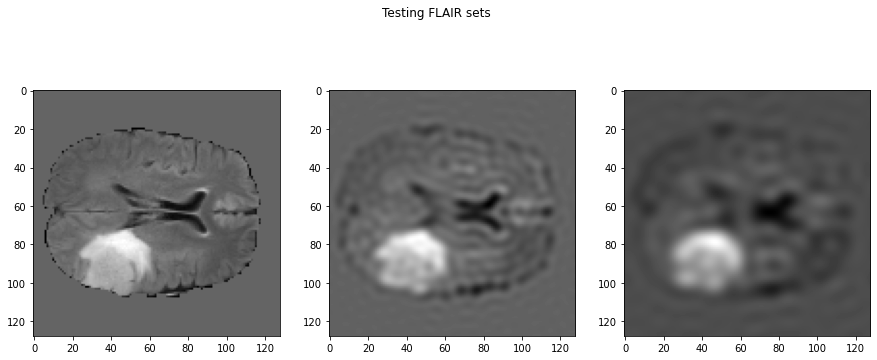

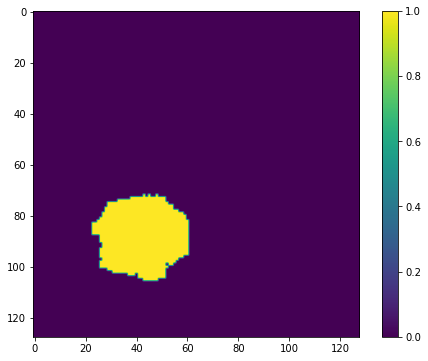

In [6]:
# FLAIR data
sample_images = [test_ds_baseline_FLAIR[20]['image'],
                 test_ds_gibbs20_FLAIR[20]['image'],
                 test_ds_gibbs12p5_FLAIR[20]['image'],]

label = test_ds_baseline_FLAIR[20]['label']

print(sample_images[0].size())
print(label.size())


plt.figure(figsize=(15,6))
plt.suptitle('Testing FLAIR sets ')
for i in range(len(sample_images)):
    plt.subplot(1,len(sample_images),i+1)
    plt.imshow(sample_images[i][0, :, :, 32].detach().cpu(), cmap="gray")
plt.show()
    

# also visualize the 3 channels label corresponding to this image
plt.figure("label", (8, 6))
plt.imshow(label[0, :, :, 32].detach().cpu())
plt.colorbar()
plt.show()

torch.Size([1, 128, 128, 64])
torch.Size([1, 128, 128, 64])


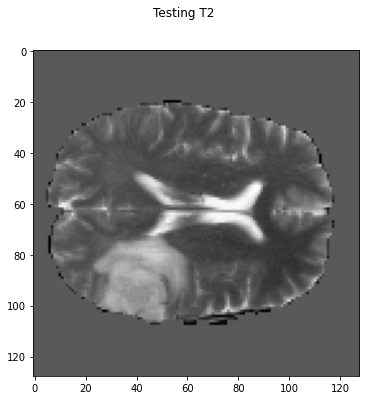

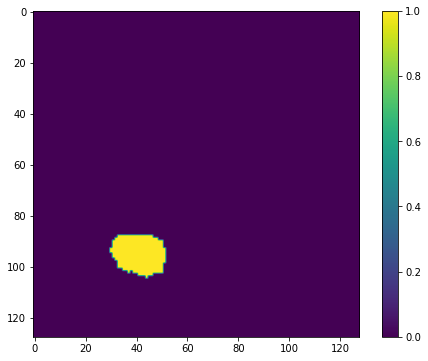

In [7]:
# T2 data
sample_images_T2 = [test_ds_baseline_T2[20]['image']]

label_T2 = test_ds_baseline_T2[20]['label']

print(sample_images_T2[0].size())
print(label.size())


plt.figure(figsize=(12,6))
plt.suptitle('Testing T2 ')
for i in range(len(sample_images_T2)):
    plt.subplot(1,len(sample_images_T2),i+1)
    plt.imshow(sample_images_T2[i][0, :, :, 32].detach().cpu(), cmap="gray")
plt.show()
    

# also visualize the 3 channels label corresponding to this image
plt.figure("label", (8, 6))
plt.imshow(label_T2[0, :, :, 32].detach().cpu())
plt.colorbar()
plt.show()

# Inference

In [20]:
epoch_loss_baseline_FLAIR = np.loadtxt('/vol/bitbucket/yc7620/90_data/52_MONAI_DATA_DIRECTORY/10_training_results/imperial_project_data/baseline_model_FLAIRmod_WT/epoch_loss_values_baseline_model_FLAIRmod_WT.txt')

epoch_loss_gibbs12p5_FLAIR = np.loadtxt('/vol/bitbucket/yc7620/90_data/52_MONAI_DATA_DIRECTORY/10_training_results/imperial_project_data/stylized_model_gibbs12.5_FLAIRmod_WT/epoch_loss_values_stylized_model_gibbs12.5_FLAIRmod_WT.txt')

epoch_loss_gibbs20_FLAIR = np.loadtxt('/vol/bitbucket/yc7620/90_data/52_MONAI_DATA_DIRECTORY/10_training_results/imperial_project_data/stylized_model_gibbs20_FLAIRmod_WT/epoch_loss_values_stylized_model_gibbs20_FLAIRmod_WT.txt')

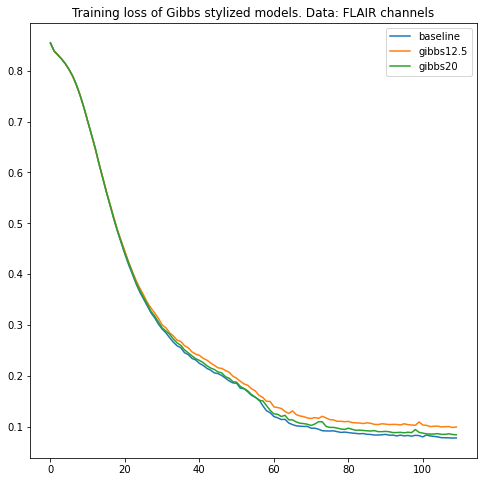

In [24]:
plt.figure(figsize=(8,8))
plt.plot(range(len(epoch_loss_baseline_FLAIR)), epoch_loss_baseline_FLAIR, label='baseline')
# plt.hlines([.075, .19, .1],0,180, colors='k')
plt.plot(range(len(epoch_loss_baseline_FLAIR)), epoch_loss_gibbs12p5_FLAIR, label='gibbs12.5')
plt.plot(range(len(epoch_loss_baseline_FLAIR)), epoch_loss_gibbs20_FLAIR, label='gibbs20')
plt.legend()
plt.title('Training loss of Gibbs stylized models. Data: FLAIR channels')
plt.show()

## Check models' output with the input image and label from same modality

In [25]:
baseline.eval()
with torch.no_grad():
    plt.figure("label", (18, 6))
    plt.imshow(label[0, :, :, 32].detach().cpu())
    plt.colorbar()
    plt.show()
    for i in range(len(sample_images)):
        # select one image to evaluate and visualize the model output
        val_input = sample_images[i].unsqueeze(0).to(device)
        val_output = baseline(val_input)
#         plt.figure("image", (24, 6))
#         plt.imshow(sample_images[i][0,:,:,32].detach().cpu(), cmap="gray")
#         plt.show()


        # visualize the 3 channels model output corresponding to this image
        plt.figure("baseline", (18, 6))
        plt.title('Baseline model prediction on baseline data')
        plt.imshow(torch.sigmoid(val_output[0, 0, :, :, 32].detach().cpu()))
        plt.colorbar()
        plt.show()
    

#     # Gibbs15 model/data 
#     gibbs15.model.eval()
#     val_input = img_gibbs15.unsqueeze(0).to(device)
#     val_output = gibbs15.model(val_input)
#     plt.figure("gibbs15", (18, 6))
#     plt.suptitle('Gibbs15 model prediction on Gibbs15 data')
#     for i in range(3):
#         plt.subplot(1, 3, i + 1)
#         plt.title(f"output channel {i}")
#         plt.imshow(torch.sigmoid(val_output[0, i, :, :, 32].detach().cpu()))
#         plt.colorbar()
#     plt.show()

NameError: name 'baseline' is not defined

## Check models' output with the input image and label from same modality

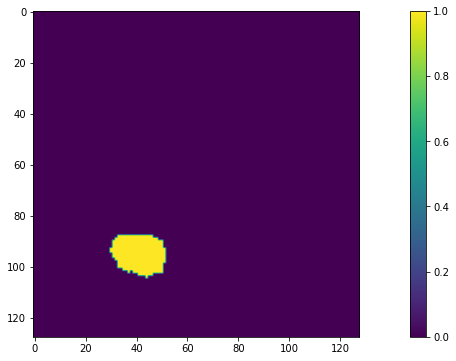

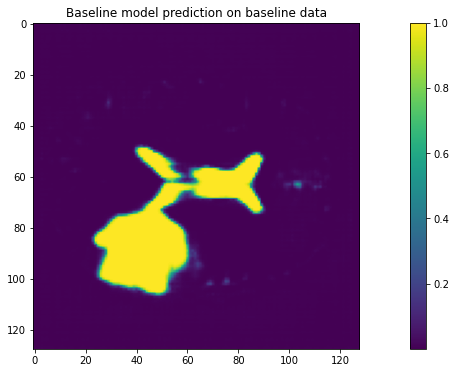

In [120]:
baseline.eval()
with torch.no_grad():
    plt.figure("label", (18, 6))
    plt.imshow(label_T2[0, :, :, 32].detach().cpu())
    plt.colorbar()
    plt.show()
    for i in range(len(sample_images_T2)):
        # select one image to evaluate and visualize the model output
        val_input = sample_images_T2[i].unsqueeze(0).to(device)
        val_output = baseline(val_input)
#         plt.figure("image", (24, 6))
#         plt.imshow(sample_images[i][0,:,:,32].detach().cpu(), cmap="gray")
#         plt.show()


        # visualize the 3 channels model output corresponding to this image
        plt.figure("baseline", (18, 6))
        plt.title('Baseline model prediction on baseline data')
        plt.imshow(torch.sigmoid(val_output[0, 0, :, :, 32].detach().cpu()))
        plt.colorbar()
        plt.show()

## Model comparisons

### Evaluations

In [34]:
path = '/vol/bitbucket/yc7620/90_data/52_MONAI_DATA_DIRECTORY/10_training_results/imperial_project_data/baseline_model_FLAIRmod_WT/baseline_model_FLAIRmod_WT.pth'
baseline_eval = model_evaluation(path, 'baseline model', in_channels=1, out_channels=1)
baseline_eval.add_eval('baseline_data', test_loader_baseline_FLAIR)
baseline_eval.add_eval('gibbs12.5_FLAIR', test_loader_gibbs12p5_FLAIR)
baseline_eval.add_eval('gibbs20_FLAIR', test_loader_gibbs20_FLAIR)
baseline_eval.add_eval('T2', test_loader_baseline_T2)

# path = '/vol/bitbucket/yc7620/90_data/52_MONAI_DATA_DIRECTORY/10_training_results/imperial_project_data/stylized_model_gibbs12.5_FLAIRmod_WT/stylized_model_gibbs12.5_FLAIRmod_WT.pth'
# gibbs12p5 = model_evaluation(path, 'gibbs12.5', in_channels=1, out_channels=1)
# gibbs12p5.add_eval('baseline_data', test_loader_baseline_FLAIR)
# gibbs12p5.add_eval('gibbs12.5_FLAIR', test_loader_gibbs12p5_FLAIR)
# gibbs12p5.add_eval('gibbs20_FLAIR', test_loader_gibbs20_FLAIR)
# gibbs12p5.add_eval('T2', test_loader_baseline_T2)

# path = '/vol/bitbucket/yc7620/90_data/52_MONAI_DATA_DIRECTORY/10_training_results/imperial_project_data/stylized_model_gibbs20_FLAIRmod_WT/stylized_model_gibbs20_FLAIRmod_WT.pth'
# gibbs20 = model_evaluation(path, 'gibbs20', in_channels=1, out_channels=1)
# gibbs20.add_eval('baseline_data', test_loader_baseline_FLAIR)
# gibbs20.add_eval('gibbs12.5_FLAIR', test_loader_gibbs12p5_FLAIR)
# gibbs20.add_eval('gibbs20_FLAIR', test_loader_gibbs20_FLAIR)
# gibbs20.add_eval('T2', test_loader_baseline_T2)

100%|██████████| 24/24 [00:15<00:00,  1.51it/s]


In [35]:
baseline_eval.eval_dict

defaultdict(list,
            {'baseline_data': 0.8803316528598467,
             'gibbs12.5_FLAIR': 0.7329129228989283,
             'gibbs20_FLAIR': 0.8200558573007584,
             'T2': 0.33618340206642944})

In [32]:
gibbs12p5.eval_dict

defaultdict(list,
            {'baseline_data': 0.8602173527081808,
             'gibbs12.5_FLAIR': 0.8614373877644539,
             'gibbs20_FLAIR': 0.864605558415254,
             'T2': 0.32359230347598594})

In [36]:
gibbs20.eval_dict

defaultdict(list,
            {'baseline_data': 0.858008474111557,
             'gibbs12.5_FLAIR': 0.8481988136967024,
             'gibbs20_FLAIR': 0.8705579762657484,
             'T2': 0.3126896614236709})

### Load saved metrics

We load saved model_evaluations if they exist.

In [17]:
%ls

80_learning_curves/                     Gibbs12.5_model.pickle
baseline_model_2.pickle                 Gibbs15_model.pickle
baseline_model.pickle                   Gibbs20_model.pickle
brats_segmentation_3d_Gibbs_test.ipynb  Gibbs25_model.pickle
Gibbs10_model.pickle                    Gibbs9_model.pickle


In [53]:
baseline = model_evaluation(None,instance_name='baseline model')
gibbs25 = model_evaluation(None, instance_name='Gibbs25_model')
gibbs20 = model_evaluation(None,instance_name='Gibbs25_model')
gibbs15 = model_evaluation(None,instance_name='Gibbs15_model')
gibbs12p5 = model_evaluation(None,instance_name='Gibbs12.5_model')
gibbs10 = model_evaluation(None,instance_name='Gibbs10_model')
gibbs9 = model_evaluation(None,instance_name='Gibbs9_model')

baseline.load_dict('baseline_model.pickle')
gibbs25.load_dict('Gibbs25_model.pickle')
gibbs20.load_dict('Gibbs20_model.pickle')
gibbs15.load_dict('Gibbs15_model.pickle')
gibbs12p5.load_dict('Gibbs12.5_model.pickle')
gibbs10.load_dict('Gibbs10_model.pickle')
gibbs9.load_dict('Gibbs9_model.pickle')

In [88]:
def plot_model_performance(gibbs_values:list, model_evals:list, metric:str, figsize:tuple = None, xlim:tuple=None, ylim:tuple=None):
    '''
    Plots each model's performance over a range of stylized 
    datasets.
    
    Args: 
        gibbs_values = list of Gibbs values associated with each
            test dataset.
        model_evals = instances of the model_evaluation class
            for each model to evaluate.
        metric = one of [mean, et, tc, wt].
    '''
    metrics_map ={'mean':0, 'et':1, 'tc':2, 'wt':3}
    keys = model_evals[0].eval_dict.keys()
    plt.figure(figsize=figsize)
    for model in model_evals:
        vals = []
        for k in keys:
            vals.append(dict(model.eval_dict)[k][metrics_map[metric]])
        plt.plot(gibbs_values,list(reversed(vals)),'-*',label=model.instance_name)
    plt.legend()
    plt.xlabel('Gibbs-stylized test data')
    plt.title(metric+' Dice score for each Gibbs-stylized model')
    if xlim:
        plt.xlim(*xlim)
    if ylim:
        plt.ylim(*ylim)
        plt.yticks(np.arange(min(ylim), max(ylim), .02))
    plt.show()
    